In [1]:
#importing necessary modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score



In [2]:
data=pd.read_csv('Bank Customer Churn Prediction.csv')
data.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
data.shape

(10000, 12)

In [4]:
# Replace string 'NaN' with NaN values
data = data.replace('NaN', np.nan,regex=True)

In [5]:
#Checking missing data
data.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

In [6]:
data.dtypes

customer_id           int64
credit_score          int64
country              object
gender               object
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
churn                 int64
dtype: object

**EDA**

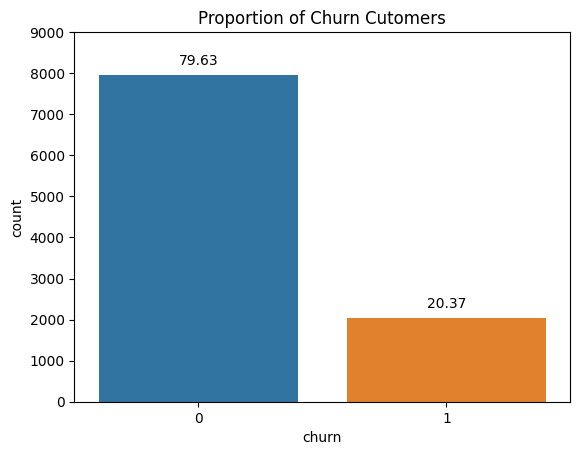

In [7]:
bar=sns.countplot(x='churn',data=data,palette='tab10')
plt.ylim(0,9000)
for p in bar.patches:
    bar.annotate(format(p.get_height()/len(data)*100, '.2f'), (p.get_x() + p.get_width() / 2, p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.title("Proportion of Churn Cutomers")
plt.show()



As you can see the classes are imbalance, the data of churn customers is significantly lower than other customers which might effect the accuracy of our model.

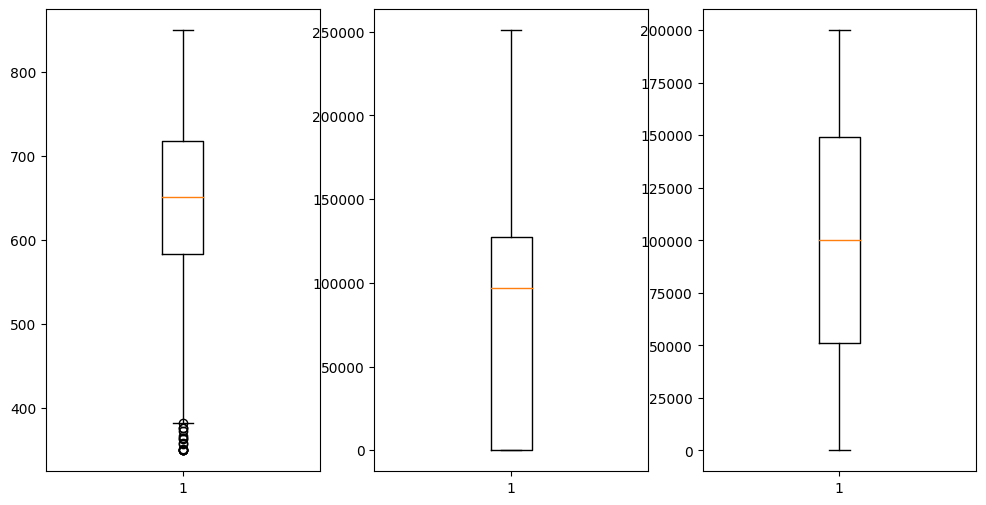

In [8]:
cols=['credit_score','balance','estimated_salary']
fig,ax=plt.subplots(1,3,figsize=(12,6))
for i,col in enumerate(cols):
    ax[i].boxplot(data[col])

<Axes: xlabel='balance', ylabel='Count'>

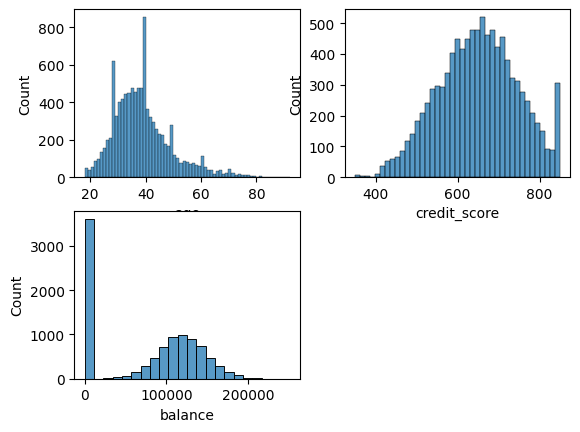

In [9]:
plt.subplot(2,2,1)
sns.histplot(data['age'],kde=False)
plt.subplot(2,2,2)
sns.histplot(data['credit_score'],kde=False)
plt.subplot(2,2,3)
sns.histplot(data['balance'],kde=False)




Text(0.5, 1.0, 'Number of churn customers at different ages')

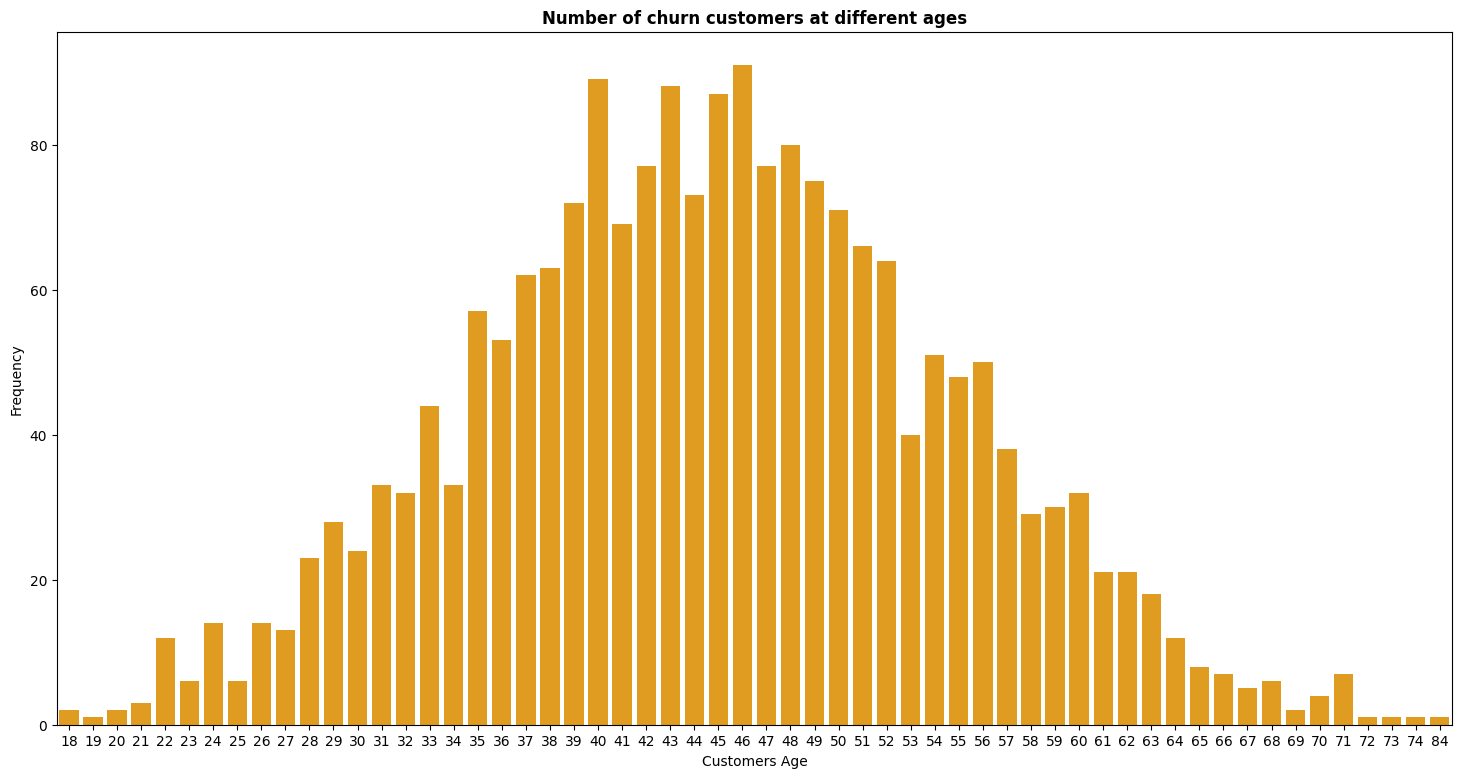

In [10]:
df=data[data['churn']==1]['age'].value_counts().rename('Frequency').reset_index()
plt.figure(figsize=(18,9))
sns.barplot(x='index',y='Frequency',data=df,color='orange')
plt.xlabel('Customers Age')
plt.title('Number of churn customers at different ages',weight='bold')

We can observe that majority of the churn customers lies between the ages 40-50

Text(0.5, 0, 'Countries')

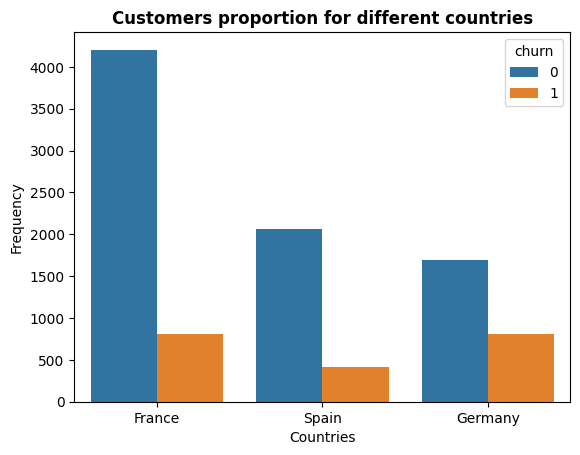

In [11]:
sns.countplot(x='country',hue='churn',data=data,palette='tab10')
plt.title('Customers proportion for different countries',weight='bold')
plt.ylabel('Frequency')
plt.xlabel('Countries')

Using this countplot we can observe that most out of all the countries mentioned Germany has high rate of churned customers.

Text(0.5, 0, 'Gender')

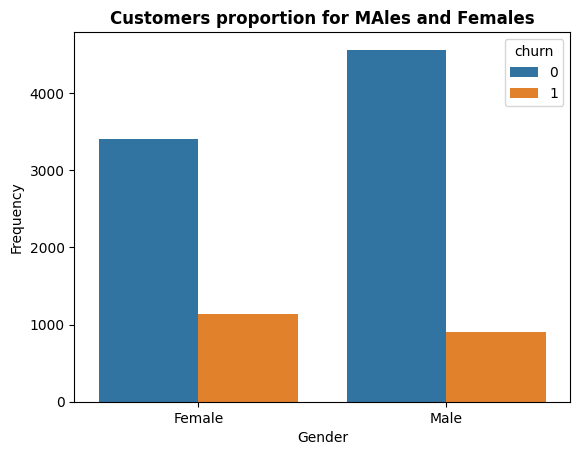

In [12]:
sns.countplot(x='gender',hue='churn',data=data,palette='tab10')
plt.title('Customers proportion for MAles and Females',weight='bold')
plt.ylabel('Frequency')
plt.xlabel('Gender')

The proportion of females is more in the churn customers

In [13]:
df=data[data['churn']==1]['tenure'].value_counts().rename('Frequency').reset_index()
df

,index,Frequency
0,1,232
1,3,213
2,9,213
3,5,209
4,4,203
5,2,201
6,8,197
7,6,196
8,7,177
9,10,101


Text(0.5, 1.0, 'Number of churn customers at different tenures')

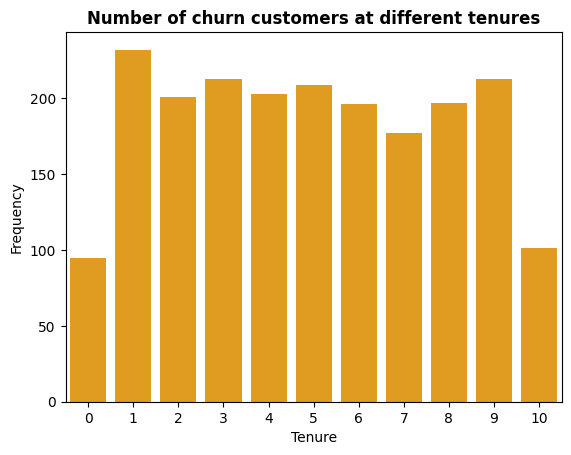

In [14]:
sns.barplot(x='index',y='Frequency',data=df,color='orange')
plt.xlabel('Tenure')
plt.title('Number of churn customers at different tenures',weight='bold')

In [15]:
cols=['products_number','credit_card','active_member']

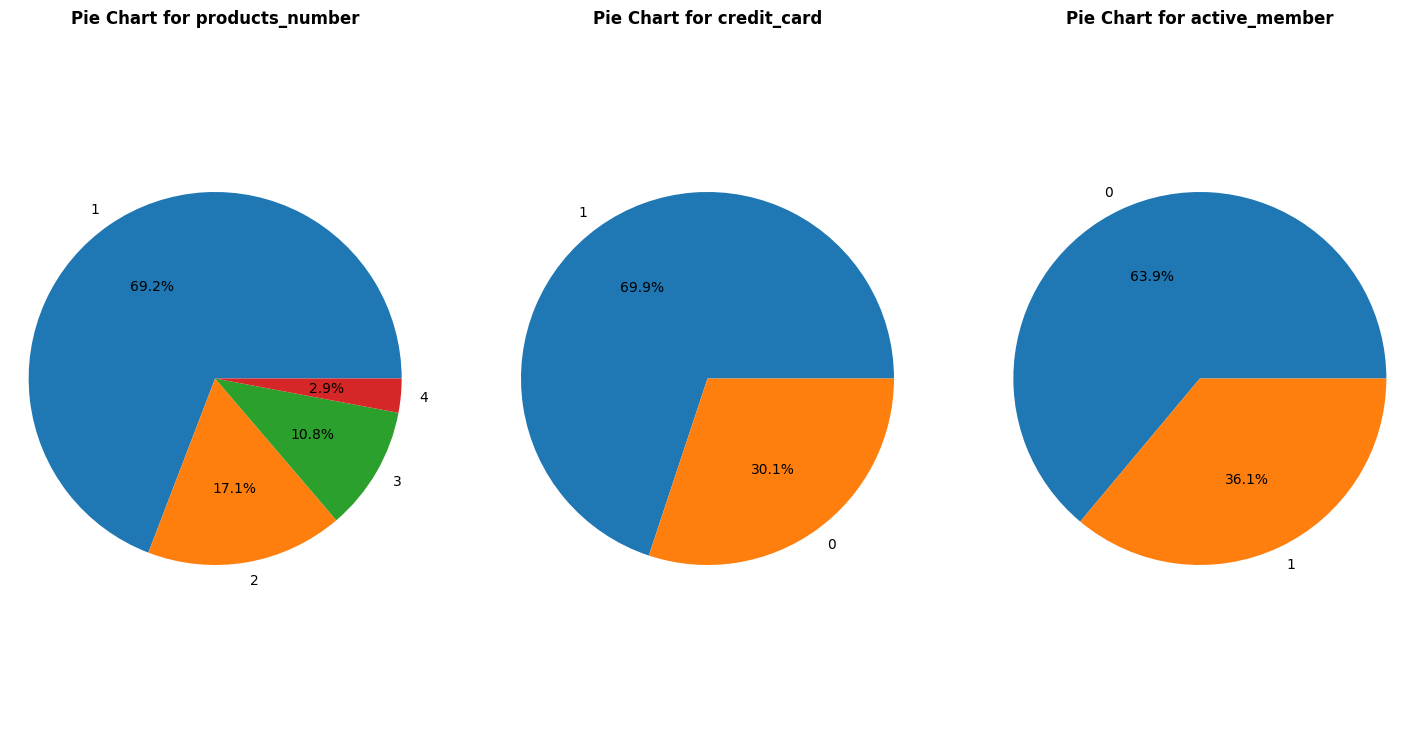

In [16]:
fig, axes = plt.subplots(1,3,figsize=(18,9))
for i, col in enumerate(cols):
    # Get the frequency count of each category where the customer has churned
    counts = data[data['churn'] == 1][col].value_counts()
    labels = counts.index
    sizes = counts.values

    ax = axes[i]  # Get the current subplot
    ax.pie(sizes, labels=labels, autopct='%1.1f%%')
    ax.axis('equal')  # Equal aspect ratio ensures circular shape
    ax.set_title("Pie Chart for %s" % (col),weight='bold')


In [17]:
target=data['churn']
data.drop(['churn'],axis=1,inplace=True)

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
X_train, X_test, Y_train, Y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# Print the shapes of the resulting datasets
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Training target set shape:", Y_train.shape)
print("Testing target set shape:", Y_test.shape)

Training set shape: (8000, 11)
Testing set shape: (2000, 11)
Training target set shape: (8000,)
Testing target set shape: (2000,)


In [19]:
print('Distribution of classes before sampling in the training dataset')
Y_train.value_counts()

Distribution of classes before sampling in the training dataset


0    6356
1    1644
Name: churn, dtype: int64

In [20]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_resampled, Y_resampled = ros.fit_resample(X_train,Y_train)

In [21]:
#after sampling
print(X_resampled.shape)
print(Y_resampled.shape)

(12712, 11)
(12712,)


In [22]:
Y_resampled.value_counts()

0    6356
1    6356
Name: churn, dtype: int64

In [23]:
ID=X_test['customer_id']
X_resampled.drop(['customer_id'],axis=1,inplace=True)
X_test.drop(['customer_id'],axis=1,inplace=True)

In [24]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
import copy
numerical_features = [ "age","estimated_salary","credit_score","balance"]
scaler = StandardScaler()
X_train_scaled = copy.deepcopy(X_resampled)
X_test_scaled = copy.deepcopy(X_test)
X_train_scaled[numerical_features] = scaler.fit_transform(X_train_scaled[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test_scaled[numerical_features])

In [25]:
cat_cols=['gender','country']

In [26]:
#Encoding my categorical labels
encoder=OneHotEncoder(sparse=False,handle_unknown='ignore',drop='first')
encoder.fit(X_train_scaled[cat_cols])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False,
              sparse_output=False)

In [27]:
def get_encoder(df):
    temp_df = pd.DataFrame(data=encoder.transform(df[cat_cols]), columns=encoder.get_feature_names_out())
    df.drop(columns=cat_cols, axis=1, inplace=True)
    df = pd.concat([df.reset_index(drop=True), temp_df], axis=1)
    return df

In [28]:
encod_train = get_encoder(X_train_scaled)
encod_test = get_encoder(X_test_scaled)

In [29]:
# Print the shapes of the resulting datasets
print("Training set shape:", encod_train.shape)
print("Testing set shape:", encod_test.shape)
print("Training target set shape:", Y_resampled.shape)
print("Testing target set shape:", Y_test.shape)

Training set shape: (12712, 11)
Testing set shape: (2000, 11)
Training target set shape: (12712,)
Testing target set shape: (2000,)


In [30]:
#creating an object for our models
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier(n_neighbors=10)))
models.append(('TREES', DecisionTreeClassifier(max_depth=10)))
models.append(('FOREST', RandomForestClassifier(max_depth=10,n_estimators=300)))
models.append(('SVM', SVC()))
models

[('LR', LogisticRegression()),
 ('KNN', KNeighborsClassifier(n_neighbors=10)),
 ('TREES', DecisionTreeClassifier(max_depth=10)),
 ('FOREST', RandomForestClassifier(max_depth=10, n_estimators=300)),
 ('SVM', SVC())]

In [31]:
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, encod_train, Y_resampled, cv=kfold, scoring='accuracy')
    print(name)
    print(cv_results)
    mean_score = np.mean(cv_results)
    print(f"Average accuracy Score for {name} is: {mean_score:.3f}")



LR
[0.70625246 0.71411718 0.69669552 0.69236821 0.68725413]
Average accuracy Score for LR is: 0.699
KNN
[0.77624853 0.78293354 0.76553895 0.76239182 0.75688434]
Average accuracy Score for KNN is: 0.769
TREES
[0.82068423 0.83955958 0.83398899 0.83123525 0.80881196]
Average accuracy Score for TREES is: 0.827
FOREST
[0.85764845 0.86315376 0.84697089 0.86703383 0.85208497]
Average accuracy Score for FOREST is: 0.857
SVM
[0.75894613 0.77034998 0.75216365 0.75727773 0.74901652]
Average accuracy Score for SVM is: 0.758


In [32]:
best_model=RandomForestClassifier(max_depth=10,n_estimators=300 )
best_model.fit(encod_train,Y_resampled)
y_pred=best_model.predict(encod_test)
classification_summary = classification_report(Y_test, y_pred)
auc_score=roc_auc_score(Y_test,y_pred)
print(f'Auc Score is :{auc_score}')
print(classification_summary)

Auc Score is :0.78996153913144
              precision    recall  f1-score   support

           0       0.93      0.87      0.90      1607
           1       0.57      0.71      0.63       393

    accuracy                           0.84      2000
   macro avg       0.75      0.79      0.76      2000
weighted avg       0.85      0.84      0.84      2000



Text(50.722222222222214, 0.5, 'Predicted Value')

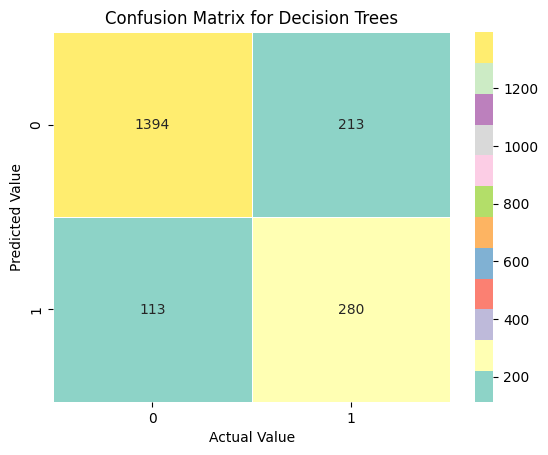

In [33]:
sns.heatmap(confusion_matrix(Y_test,y_pred), cmap = 'Set3',
            linewidth = 0.5, annot = True, fmt= 'd')
plt.title('Confusion Matrix for Decision Trees')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
